In [ ]:
!pip install scvi-tools scanpy anndata GEOparse


      Successfully uninstalled nvidia-cublas-cu12-12.5.3.2
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.1.3
    Uninstalling nvidia-cusparse-cu12-12.5.1.3:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.1.3
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [ ]:
!pip install scvelo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.8-py3-none-any.whl size=54012 sha256=bca98a56d7bc34744772e80f50419cd133cc4b5dd13988b18a9dc0bc6516cfac
  Stored in directory: /root/.cache/pip/wheels/0a/65/00/30ea772562c1e326e9a076e6a526216abc6c5456852cc2e0e4
Successfully built loompy


In [ ]:
import scvelo
import scanpy as sc
import GEOparse
import pandas as pd
import numpy as np

# loading datasets

## pbmc

  0%|          | 0.00/118M [00:00<?, ?B/s]

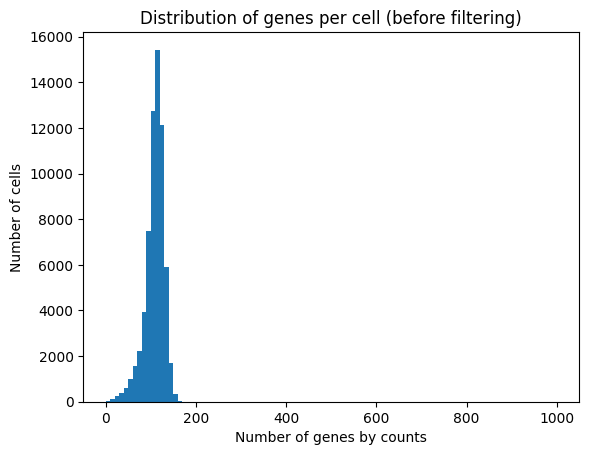

In [ ]:
data_pbmc = sc.AnnData(scvelo.datasets.pbmc68k())

pbmc_count_matrix = data_pbmc.X

adata_temp = data_pbmc.copy()
sc.pp.calculate_qc_metrics(adata_temp, inplace=True)
import matplotlib.pyplot as plt
plt.hist(adata_temp.obs['n_genes_by_counts'], bins=100, range=(0,1000)) # Adjust range as needed
plt.xlabel("Number of genes by counts")
plt.ylabel("Number of cells")
plt.title("Distribution of genes per cell (before filtering)")
plt.show()

In [ ]:
np.unique(data_pbmc.obs["celltype"]).shape

(11,)

In [ ]:
pbmc_count_matrix.shape

(65877, 33939)

In [ ]:
adata_temp.obs['n_genes_by_counts'].describe()

,n_genes_by_counts
count,65877.000000
mean,107.948738
std,21.532068
min,0.000000
25%,98.000000
50%,111.000000
75%,122.000000
max,171.000000


## deng


In [ ]:
!wget -O GSE45719.tar "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE45719&format=file"


--2025-07-02 05:55:43--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE45719&format=file
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102666240 (98M) [application/x-tar]
Saving to: ‘GSE45719.tar’

GSE45719.tar        100%[===================>]  97.91M  25.4MB/s    in 4.2s    

2025-07-02 05:55:48 (23.5 MB/s) - ‘GSE45719.tar’ saved [102666240/102666240]



In [ ]:
!tar -xvf GSE45719.tar

GSM1112490_16cell_1-10_expression.txt.gz
GSM1112491_16cell_1-11_expression.txt.gz
GSM1112492_16cell_1-12_expression.txt.gz
GSM1112493_16cell_1-13_expression.txt.gz
GSM1112494_16cell_1-14_expression.txt.gz
GSM1112495_16cell_1-15_expression.txt.gz
GSM1112496_16cell_1-2_expression.txt.gz
GSM1112497_16cell_1-3_expression.txt.gz
GSM1112498_16cell_1-4_expression.txt.gz
GSM1112499_16cell_1-5_expression.txt.gz
GSM1112500_16cell_1-6_expression.txt.gz
GSM1112501_16cell_1-7_expression.txt.gz
GSM1112502_16cell_1-8_expression.txt.gz
GSM1112503_16cell_1-9_expression.txt.gz
GSM1112504_16cell_4-1_expression.txt.gz
GSM1112505_16cell_4-10_expression.txt.gz
GSM1112506_16cell_4-11_expression.txt.gz
GSM1112507_16cell_4-2_expression.txt.gz
GSM1112508_16cell_4-3_expression.txt.gz
GSM1112509_16cell_4-4_expression.txt.gz
GSM1112510_16cell_4-5_expression.txt.gz
GSM1112511_16cell_4-6_expression.txt.gz
GSM1112512_16cell_4-7_expression.txt.gz
GSM1112513_16cell_4-8_expression.txt.gz
GSM1112514_16cell_4-9_expression

In [ ]:
import glob

# Step 1: Find all files
files = sorted(glob.glob("*.txt.gz"))  # or '*.txt' if unzipped

count_data = []
cell_names = []

for file in files:
    # Read the file and skip comments if any
    df = pd.read_csv(file, sep="\t", header=None)
    df.columns = df.loc[0,:]
    df = df.drop(0,axis=0)
    # print(df.columns)
    # Get cell name from file (e.g., '16cell_1-10')
    parts = file.split('_')
    cell_name = parts[1] + "_" + parts[2].replace(".txt.gz", "").replace(".txt", "")
    cell_names.append(cell_name)

    # Set gene as index and extract 'reads' column
    df = df[['#Gene_symbol', 'reads']].copy()
    df.set_index('#Gene_symbol', inplace=True)
    count_data.append(df['reads'])

# Merge all dataframes into a single one
deng_count_matrix = pd.concat(count_data, axis=1)
deng_count_matrix.columns = cell_names


In [ ]:
data_deng = sc.AnnData(deng_count_matrix.T)

In [ ]:
deng_labels = pd.Series(data_deng.obs.index).str.split('_').str[0]

In [ ]:
np.unique(deng_labels)

array(['16cell', '4cell', '8cell', 'BXC', 'C57twocell', 'early2cell',
       'earlyblast', 'fibroblast', 'late2cell', 'lateblast', 'mid2cell',
       'midblast', 'zy1', 'zy2', 'zy3', 'zy4'], dtype=object)

In [ ]:
deng_labels.groupby(deng_labels).count()

,0
16cell,58
4cell,14
8cell,47
BXC,13
C57twocell,8
early2cell,8
earlyblast,43
fibroblast,10
late2cell,10
lateblast,30


In [ ]:
from sklearn.preprocessing import LabelEncoder

def to_six_stages(label):
    label = label.lower()
    if label.startswith('zy'):
        return None
    elif '2cell' in label:
        return '2-cell'
    elif '4cell' in label:
        return '4-cell'
    elif '8cell' in label:
        return '8-cell'
    elif '16cell' in label:
        return '16-cell'
    elif 'blast' in label:
        return 'blastocyst'
    else:
        return 'other'  # for non-embryo or unwanted labels



In [ ]:
labels_deng = np.array([to_six_stages(l) for l in deng_labels])


In [ ]:
# prompt: how to delete rows with None label from X data

# Identify the indices where labels are None
none_indices = np.where(labels_deng == None)[0]

# Create a boolean mask where True indicates the rows to keep
keep_mask = np.ones(data_deng.shape[0], dtype=bool)
keep_mask[none_indices] = False

# Filter the AnnData object and the labels
data_deng_filtered = data_deng[keep_mask].copy()
labels_deng_filtered = labels_deng[keep_mask]

# You can now work with data_deng_filtered and labels_deng_filtered
print("Original data shape:", data_deng.shape)
print("Filtered data shape:", data_deng_filtered.shape)
print("Number of None labels removed:", len(none_indices))

Original data shape: (317, 22958)
Filtered data shape: (313, 22958)
Number of None labels removed: 4


In [ ]:
data_deng = data_deng_filtered

In [ ]:
labels_deng = pd.Series(labels_deng).dropna()
label_ = labels_deng
labels_deng = LabelEncoder().fit_transform(labels_deng)

In [ ]:
label_.groupby(labels_deng).count()

,0
0,58
1,30
2,14
3,47
4,143
5,21


In [ ]:
X_deng = data_deng.X.astype(np.float32)

print(f"Original shape: {X_deng.shape}")
# Identify columns with all zeros
zero_columns = np.where(np.all(X_deng == 0, axis=0))[0]

# Remove identified columns from the AnnData object
# Need to use .var_names to index columns in AnnData
X_deng = X_deng[:, np.delete(np.arange(X_deng.shape[1]), zero_columns)].copy()


print(f"Number of zero columns removed: {len(zero_columns)}")
print(f"New shape after removing zero columns: {X_deng.shape}")

Original shape: (313, 22958)
Number of zero columns removed: 1143
New shape after removing zero columns: (313, 21815)


In [ ]:
labels_deng.shape

(313,)

## chu

In [ ]:
%%bash
wget "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75748/suppl/GSE75748_sc_cell_type_ec.csv.gz"
wget "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75748/suppl/GSE75748_sc_time_course_ec.csv.gz"


--2025-07-02 05:56:02--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75748/suppl/GSE75748_sc_cell_type_ec.csv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23946858 (23M) [application/x-gzip]
Saving to: ‘GSE75748_sc_cell_type_ec.csv.gz’

     0K .......... .......... .......... .......... ..........  0%  436K 54s
    50K .......... .......... .......... .......... ..........  0%  868K 40s
   100K .......... .......... .......... .......... ..........  0%  874K 36s
   150K .......... .......... .......... .......... ..........  0% 91.8M 27s
   200K .......... .......... .......... .......... ..........  1% 1.82M 24s
   250K .......... .......... .......... .......... ..........  1% 1.61M 22s
   300K .......... .......... .......... .......... ..........  1% 87.9M 19s
   350K

In [ ]:
import pandas as pd

# Read the first few rows to check the format
df = pd.read_csv("GSE75748_sc_cell_type_ec.csv.gz", nrows=10)
print(df.head())
print(df.columns[:10])


  Unnamed: 0  H1_Exp1.001  H1_Exp1.002  H1_Exp1.003  H1_Exp1.004  H1_Exp1.006  \
0       MKL2        10.00       162.00         3.00        42.00         0.00   
1      CD109         6.38         2.62       166.80         9.68         7.32   
2      ABTB1         0.00        28.00         0.00         1.00         0.00   
3      MAST2         0.00       133.00        41.00         0.00         0.00   
4       KAT5         0.00         7.06        52.95        20.16         0.00   

   H1_Exp1.007  H1_Exp1.008  H1_Exp1.009  H1_Exp1.010  ...  TB_Batch2.135  \
0         2.00        18.00         0.00       182.00  ...         364.98   
1        53.89         4.63        64.54        29.93  ...          15.22   
2         9.00         0.00         0.00         0.00  ...           0.00   
3         2.00         0.00         0.00         0.00  ...         175.00   
4         6.29         0.00         0.00       103.00  ...           0.00   

   TB_Batch2.136  TB_Batch2.137  TB_Batch2.138  TB

In [ ]:
# Load the whole file
df = pd.read_csv("GSE75748_sc_cell_type_ec.csv.gz", index_col=0)
print(df.shape)
print(df.index[:5])
print(df.columns[:5])


(19097, 1018)
Index(['MKL2', 'CD109', 'ABTB1', 'MAST2', 'KAT5'], dtype='object')
Index(['H1_Exp1.001', 'H1_Exp1.002', 'H1_Exp1.003', 'H1_Exp1.004',
       'H1_Exp1.006'],
      dtype='object')


In [ ]:
import anndata

# Let's parse cell type from column names
cell_type = [col.split('_')[0] for col in df.columns]

cell_meta = pd.DataFrame({'cell_type': cell_type}, index=df.columns)

# Build AnnData object
chu = anndata.AnnData(
    X=df.values.T,   # shape: cells × genes
    obs=cell_meta,
    var=pd.DataFrame(index=df.index)
)

print(chu)
print(chu.obs["cell_type"].value_counts())


AnnData object with n_obs × n_vars = 1018 × 19097
    obs: 'cell_type'
cell_type
H1     212
NPC    173
H9     162
HFF    159
DEC    138
EC     105
TB      69
Name: count, dtype: int64


In [ ]:
# Subset to only H1 and H9 cells (embryonic stem cells)
embryonic_mask = chu.obs['cell_type'].isin(['H1', 'H9'])
data_chu = chu[embryonic_mask].copy()

print(data_chu)
print("Cell type breakdown:")
print(data_chu.obs['cell_type'].value_counts())

# # Optional: Save to disk
# embryonic_adata.write("GSE75748_embryonic_stem_cells.h5ad")


AnnData object with n_obs × n_vars = 374 × 19097
    obs: 'cell_type'
Cell type breakdown:
cell_type
H1    212
H9    162
Name: count, dtype: int64


In [ ]:
X_chu = data_chu.X.astype(np.float32)
chu_labels = LabelEncoder().fit_transform(data_chu.obs['cell_type'])


In [ ]:
X_chu.shape

(374, 19097)

# normalizing count matrix

In [ ]:
from scipy.sparse import issparse

def normalize_data(adata, copy=True, highly_genes = None, filter_min_counts=True, size_factors=True,
              normalize_input=True, logtrans_input=True,min_genes=200):
    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()
    elif isinstance(adata, str):
        adata = sc.read(adata)
    else:
        raise NotImplementedError

    # Ensure that adata.X is the un-normalized count data
    norm_error = 'Make sure that the dataset (adata.X) contains unnormalized count data.'
    assert 'n_count' not in adata.obs, norm_error
    if adata.X.size < 50e6: # check if adata.X is integer only if array is small
        if issparse(adata.X):
            assert (adata.X.astype(int) != adata.X).nnz == 0, norm_error
        else:
            assert np.all(adata.X.astype(int) == adata.X), norm_error

    if filter_min_counts:
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.filter_cells(adata, min_genes=min_genes)

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if highly_genes != None:
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes = highly_genes, subset=True)

    if normalize_input:
        sc.pp.scale(adata)

    return adata



#methods implementations


## method functions


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap


import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score, adjusted_rand_score, silhouette_score


def pca_(n_components,X):
    pca = PCA(n_components=n_components)

    return pca.fit_transform(X)

def kmeans_(n_clusters,X):
    kmean = KMeans(n_clusters =n_clusters)

    return kmean.fit_predict(X)


def tsne_(n_components,X,method='barnes_hut'):
    if n_components >= 4 and method == 'barnes_hut':
        print("Warning: n_components >= 4 for t-SNE with 'barnes_hut' method. Switching to 'exact' method.")
        method = 'exact'
    # Handle the case where 'exact' is not supported for sparse matrices.
    if method == 'exact' and hasattr(X, 'format'): # Check if X is a sparse matrix
        print("Warning: 'exact' method for t-SNE does not support sparse matrices. Consider converting to dense or using 'barnes_hut' with n_components < 4.")
        # You might want to raise an error or return None here depending on desired behavior
        raise ValueError("'exact' method for t-SNE does not support sparse matrices.")

    tsne = TSNE(n_components=n_components,init='random',method=method,random_state=0)

    return tsne.fit_transform(X)

def umap_(n_components,X,n_neighbors=15,min_dist=0.1,metric='euclidean'):
    ump = umap.UMAP(n_components=n_components,n_neighbors=n_neighbors,min_dist=min_dist,metric=metric)

    return ump.fit_transform(X)




# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    """
    A Variational Autoencoder (VAE) model implemented in PyTorch.
    """
    def __init__(self, original_dim, intermediate_dim, n_components):
        super(VAE, self).__init__()

        # --- Encoder ---
        # The encoder maps the input data to the latent space.
        # It consists of two linear layers.
        self.fc1 = nn.Linear(original_dim, intermediate_dim)
        # Two output layers from the encoder: one for the mean (mu) and one for the log variance (logvar).
        self.fc21 = nn.Linear(intermediate_dim, n_components) # mu
        self.fc22 = nn.Linear(intermediate_dim, n_components) # logvar

        # --- Decoder ---
        # The decoder maps the latent space representation back to the original data space.
        self.fc3 = nn.Linear(n_components, intermediate_dim)
        self.fc4 = nn.Linear(intermediate_dim, original_dim)

    def encode(self, x):
        """
        Encodes the input by passing it through the encoder network and
        returns the latent mean and log variance.
        """
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """
        Performs the reparameterization trick to allow for backpropagation.
        z = mu + epsilon * std
        where epsilon is a random sample from a standard normal distribution.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sample from standard normal distribution
        return mu + eps * std

    def decode(self, z):
        """
        Decodes the latent vector z by passing it through the decoder network
        and returns the reconstructed input.
        """
        h3 = F.relu(self.fc3(z))
        # Use sigmoid to ensure output values are between 0 and 1, suitable for image data.
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        """
        The full forward pass of the VAE.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    """
    Calculates the VAE loss, which is the sum of reconstruction loss and KL divergence.
    """
    # Binary Cross-Entropy is a common reconstruction loss for data in [0, 1].

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch, model, train_loader, optimizer):
    """
    The training loop for a single epoch.
    """
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


def vae_(n_components, X,epochs=500):
    """
    Main function to initialize, train a VAE, and return the encoded data.

    Args:
        n_components (int): The dimensionality of the latent space.
        X (torch.Tensor): The input data tensor of shape (n_samples, n_features).

    Returns:
        A tuple containing:
        - model (VAE): The trained VAE model.
        - z_mu (np.ndarray): The mean of the latent space representation (the reduced data).
    """
    original_dim = X.shape[1]
    intermediate_dim = 400 # A common choice for MNIST
    batch_size = 128
    # Create a DataLoader for the input data
    # We add dummy labels as DataLoader expects a tuple of (data, labels)
    dataset = TensorDataset(X, torch.zeros(X.shape[0]))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # print("hello")

    # Initialize the model and optimizer
    model = VAE(original_dim, intermediate_dim, n_components).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # --- Training Loop ---
    for epoch in range(1, epochs + 1):
        train(epoch, model, dataloader, optimizer)

    # print("hello0")
    # --- Get Latent Representation ---
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Encode the full dataset to get the latent space representation
        # We only need mu for the final dimensionality-reduced output
        # print("hello")
        z_mu, _ = model.encode(X)

    # print("hello2")
    # Return the model and the latent means as a NumPy array
    return z_mu.cpu().numpy()


function_mappings = {"pca":pca_,"tsne":tsne_,"umap":umap_,"zifa":zifa_,"vae":vae_}

In [ ]:
import matplotlib.pyplot as plt
from time import time


def plot2_d(X,labels,f_name):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(f'KMeans Clustering on {f_name}-reduced scRNA-seq Data')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='KMeans Label')
    plt.show()

def results_plotting2d(X,function_name,n_clusters,sampling=False,sampling_size=2000):
    start = time()
    result = function_mappings[function_name](2,X)
    end = time()
    labels = kmeans_(n_clusters=n_clusters,X=result)
    if sampling:
        indices = np.random.choice(result.shape[0], size=sampling_size, replace=False)
        sampled_result = result[indices]
        sampled_label = labels[indices]
        plot2_d(sampled_result,sampled_label,function_name)
    else:
      plot2_d(result,labels,function_name)


    return end - start

def plot_results(evaluation_results):
      methods = list(evaluation_results.keys())
      metrics = list(evaluation_results['pca'].keys())
      metrics.remove("time")
      n_methods = len(methods)
      n_metrics = len(metrics)

      # Create an array of scores for plotting
      scores = np.array([[evaluation_results[method][metric] for method in methods] for metric in metrics])

      # --- 3. Create the grouped bar chart ---
      x = np.arange(n_methods)  # the label locations
      width = 0.25  # the width of the bars
      fig, ax = plt.subplots(figsize=(12, 7))

      # Create bars for each metric
      for i in range(n_metrics):
          offset = width * (i - (n_metrics - 1) / 2)
          rects = ax.bar(x + offset, scores[i], width, label=metrics[i])
          ax.bar_label(rects, padding=3, fmt='%.2f', fontsize=9)

      # --- 4. Add labels, title, and legend ---
      ax.set_ylabel('Scores')
      ax.set_title('Comparison of Clustering Performance by Dimensionality Reduction Method')
      ax.set_xticks(x)
      ax.set_xticklabels(methods)
      ax.legend(title="Metrics", bbox_to_anchor=(1.04, 1), loc="upper left")

      # Add a grid for better readability
      ax.yaxis.grid(True, linestyle='--', alpha=0.7)
      ax.set_ylim(0, max(scores.flatten()) * 1.15) # Add some space at the top

      fig.tight_layout()
      plt.show()

## evaluation functions


In [ ]:

from sklearn.metrics import accuracy_score, adjusted_mutual_info_score, adjusted_rand_score, silhouette_score

def evaluate_clustering(original_labels, predicted_labels, data_reduced):
  """
  Evaluates clustering results using various metrics.

  Args:
    original_labels (np.ndarray): The true labels of the data.
    predicted_labels (np.ndarray): The cluster labels predicted by KMeans.
    data_reduced (np.ndarray): The data after dimensionality reduction.

  Returns:
    dict: A dictionary containing the evaluation scores.
  """
  accuracy = accuracy_score(original_labels, predicted_labels)
  ami = adjusted_mutual_info_score(original_labels, predicted_labels)
  ari = adjusted_rand_score(original_labels, predicted_labels)
  silhouette = silhouette_score(data_reduced, predicted_labels)

  return {
      "Accuracy": accuracy,
      "AMI": ami,
      "ARI": ari,
      "Silhouette Score": silhouette
  }

def test_clustering_methods(X, original_labels, n_clusters,n_components,methods=["pca", "tsne", "umap"]):
  """
  Tests different dimensionality reduction methods followed by KMeans clustering
  and evaluates the results.

  Args:
    X (np.ndarray): The input data matrix.
    original_labels (np.ndarray): The true labels of the data.
    n_clusters (int): The number of clusters for KMeans.

  Returns:
    dict: A dictionary containing the evaluation results for each method.
  """
  results = {}
  # methods = ["pca", "tsne", "umap"]

  for method_name in methods:
    print(f"Testing {method_name} + KMeans...")
    s  = time()
    data_reduced = function_mappings[method_name](n_components, X)
    e = time()
    print(data_reduced.shape)
    predicted_labels = kmeans_(n_clusters=n_clusters, X=data_reduced)
    scores = evaluate_clustering(original_labels, predicted_labels, data_reduced)
    results[method_name] = scores
    results[method_name]["time"] = e - s

    print(f"  {method_name} results: {scores}")

  return results

# evaluate algorithms on datasets


## deng

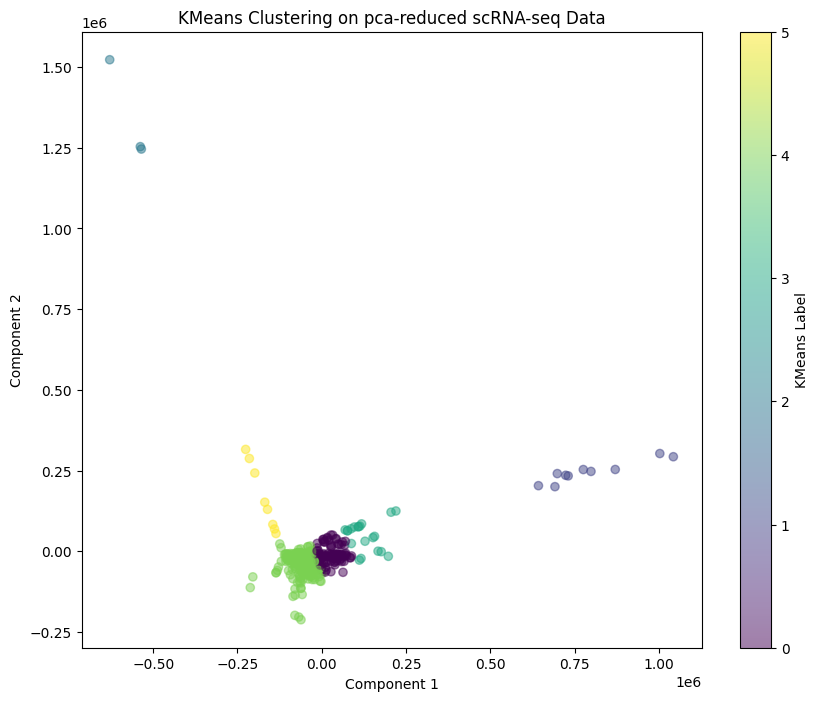

time = 0.5447537899017334


In [ ]:
t_pca_deng = results_plotting2d(X_deng,"pca",n_clusters=6)
print(f"time = {t_pca_deng }")

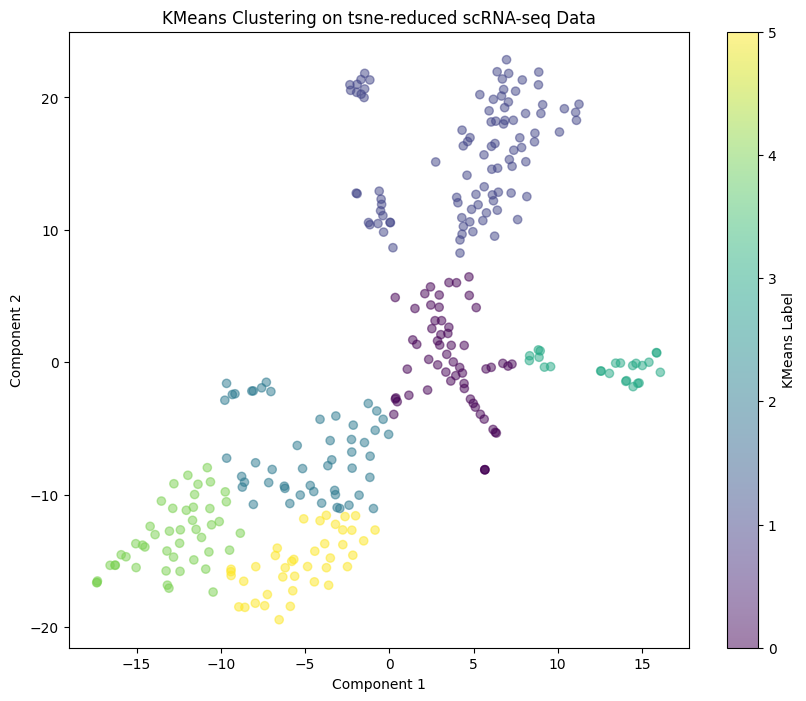

time = 1.6733014583587646


In [ ]:
t_tsne_deng = results_plotting2d(X_deng,"tsne",n_clusters=6)
print(f"time = {t_tsne_deng}")

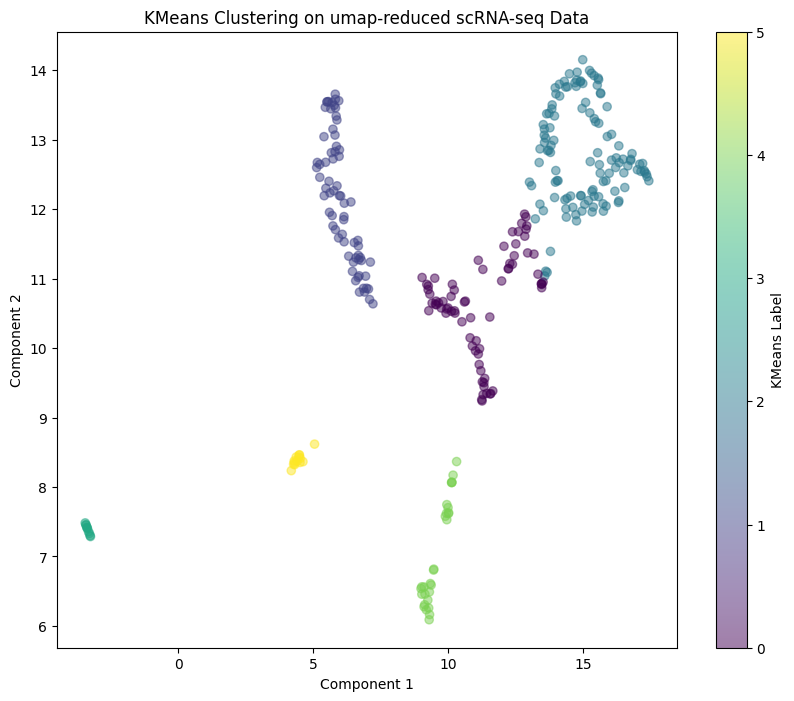

time = 9.022167921066284


In [ ]:
t_umap_deng = results_plotting2d(X_deng,"umap",n_clusters=6)
print(f"time = {t_umap_deng}")

cuda
tensor(True, device='cuda:0')
====> Epoch: 1 Average loss: 14298.3986
====> Epoch: 2 Average loss: 8947.8217
====> Epoch: 3 Average loss: 5901.7981
====> Epoch: 4 Average loss: 4981.8891
====> Epoch: 5 Average loss: 4856.0724
====> Epoch: 6 Average loss: 4398.1162
====> Epoch: 7 Average loss: 4231.0657
====> Epoch: 8 Average loss: 4016.0632
====> Epoch: 9 Average loss: 3950.4197
====> Epoch: 10 Average loss: 3853.0912
====> Epoch: 11 Average loss: 3699.1783
====> Epoch: 12 Average loss: 3652.3024
====> Epoch: 13 Average loss: 3592.2407
====> Epoch: 14 Average loss: 3535.7584
====> Epoch: 15 Average loss: 3494.4014
====> Epoch: 16 Average loss: 3415.8480
====> Epoch: 17 Average loss: 3377.5625
====> Epoch: 18 Average loss: 3342.0253
====> Epoch: 19 Average loss: 3311.8204
====> Epoch: 20 Average loss: 3301.8992
====> Epoch: 21 Average loss: 3272.7151
====> Epoch: 22 Average loss: 3265.9443
====> Epoch: 23 Average loss: 3225.7589
====> Epoch: 24 Average loss: 3233.1142
====> Epoch: 

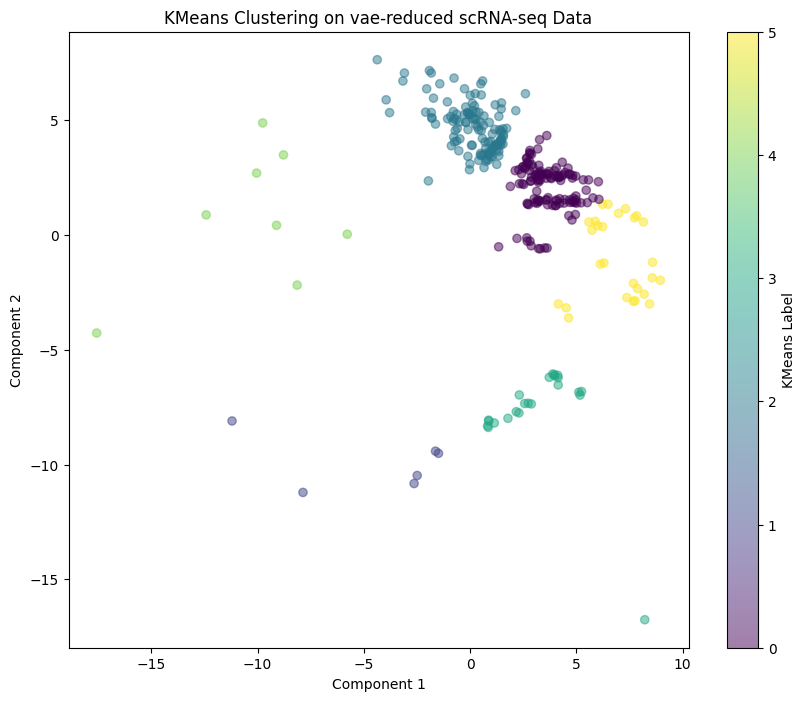

In [ ]:

def test_vae(X):

    from sklearn.preprocessing import MinMaxScaler


    # Assuming X_deng is your raw data in a NumPy array
    # 1. Scale the data to the [0, 1] range
    scaler = MinMaxScaler(clip=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # if device.type == 'cuda':
    #     torch.cuda.synchronize()

    X_scaled = scaler.fit_transform(X)

    print(device)
    # 2. Convert the scaled data to a PyTorch tensor
    X_deng_torch = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    in_bounds = ((X_deng_torch >= 0) & (X_deng_torch <= 1)).all()

    print(in_bounds)  # prints: tensor(True) if all in [0,1], else tensor(False)
    t4 = results_plotting2d(X_deng_torch,"vae",n_clusters=6)

    return t4,X_deng_torch

vae_time_deng,X_deng_torch= test_vae(X_deng)

# print(f"time = {t4}")

In [ ]:
X_deng_torch.shape

torch.Size([313, 21815])

In [ ]:


# Get original labels
original_labels = labels_deng

# Assuming the number of unique cell types is the target number of clusters
n_clusters = len(np.unique(original_labels))
print(n_clusters)
# Run the tests
evaluation_results = test_clustering_methods(X_deng, original_labels, n_clusters,n_components=100,methods = ["pca", "tsne", "umap"])

print("\nOverall Evaluation Results:")
for method, scores in evaluation_results.items():
  print(f"{method}: {scores}")


6
Testing pca + KMeans...
(313, 100)
  pca results: {'Accuracy': 0.2012779552715655, 'AMI': np.float64(0.33220674936299915), 'ARI': 0.11526364894504199, 'Silhouette Score': np.float32(0.3051357), 'time': 1.1646931171417236}
Testing tsne + KMeans...
(313, 100)
  tsne results: {'Accuracy': 0.14696485623003194, 'AMI': np.float64(0.33920286564368685), 'ARI': 0.2253394728891951, 'Silhouette Score': np.float32(0.12752055), 'time': 17.775462865829468}
Testing umap + KMeans...
(313, 100)
  umap results: {'Accuracy': 0.20766773162939298, 'AMI': np.float64(0.6943797078894774), 'ARI': 0.7652220072393247, 'Silhouette Score': np.float32(0.68400085), 'time': 1.339308261871338}

Overall Evaluation Results:
pca: {'Accuracy': 0.2012779552715655, 'AMI': np.float64(0.33220674936299915), 'ARI': 0.11526364894504199, 'Silhouette Score': np.float32(0.3051357), 'time': 1.1646931171417236}
tsne: {'Accuracy': 0.14696485623003194, 'AMI': np.float64(0.33920286564368685), 'ARI': 0.2253394728891951, 'Silhouette Sco

In [ ]:
# testing vae
evaluation_results_vae = test_clustering_methods(X_deng_torch, original_labels, n_clusters,n_components=100,methods = ["vae"])


Testing vae + KMeans...
====> Epoch: 1 Average loss: 14512.4884
====> Epoch: 2 Average loss: 9679.3842
====> Epoch: 3 Average loss: 7152.3911
====> Epoch: 4 Average loss: 5460.4153
====> Epoch: 5 Average loss: 5208.0619
====> Epoch: 6 Average loss: 4639.4289
====> Epoch: 7 Average loss: 4519.6399
====> Epoch: 8 Average loss: 4196.9190
====> Epoch: 9 Average loss: 4099.0786
====> Epoch: 10 Average loss: 3969.3176
====> Epoch: 11 Average loss: 3896.6755
====> Epoch: 12 Average loss: 3830.1271
====> Epoch: 13 Average loss: 3719.9713
====> Epoch: 14 Average loss: 3688.5151
====> Epoch: 15 Average loss: 3621.3298
====> Epoch: 16 Average loss: 3587.0789
====> Epoch: 17 Average loss: 3580.0420
====> Epoch: 18 Average loss: 3552.5634
====> Epoch: 19 Average loss: 3524.2893
====> Epoch: 20 Average loss: 3489.7008
====> Epoch: 21 Average loss: 3478.9846
====> Epoch: 22 Average loss: 3449.4051
====> Epoch: 23 Average loss: 3428.6940
====> Epoch: 24 Average loss: 3391.2877
====> Epoch: 25 Average 

In [ ]:
evaluation_results.update(evaluation_results_vae)

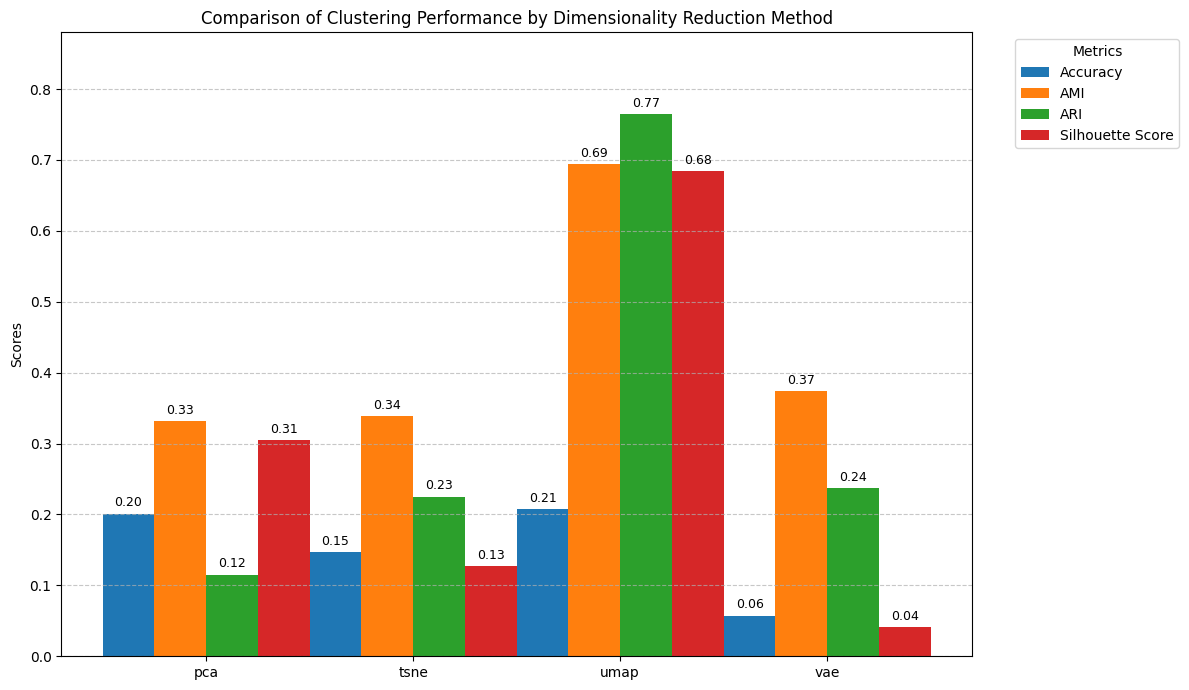

In [ ]:
plot_results(evaluation_results)

## pbmc

In [ ]:
pbmc_labels = LabelEncoder().fit_transform(data_pbmc.obs['celltype'])

In [ ]:
np.unique(pbmc_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
normalized_data = normalize_data(data_pbmc, highly_genes=2000,min_genes=140)

X_normalized= normalized_data.X

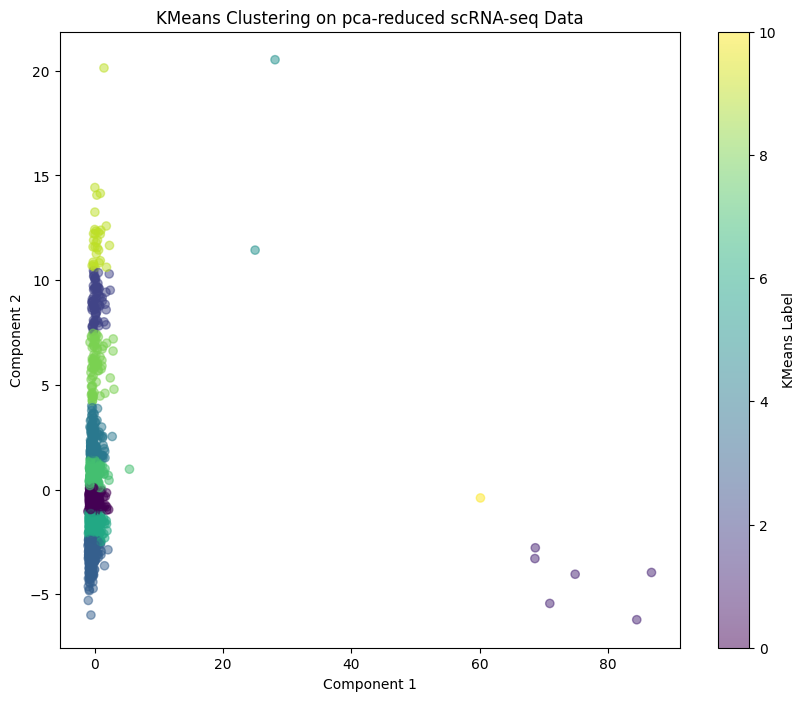

time: 0.8450088500976562


In [ ]:
t_pca = results_plotting2d(X_normalized,"pca", n_clusters=11)
print(f"time: {t_pca}")

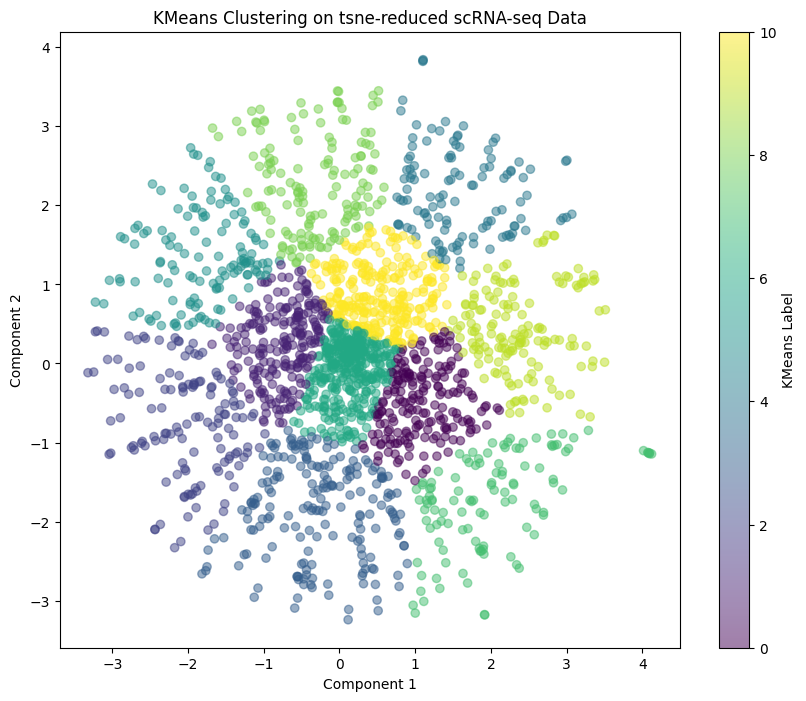

time: 29.781370639801025


In [ ]:
t_tsne = results_plotting2d(X_normalized,"tsne", n_clusters=11)
print(f"time: {t_tsne}")

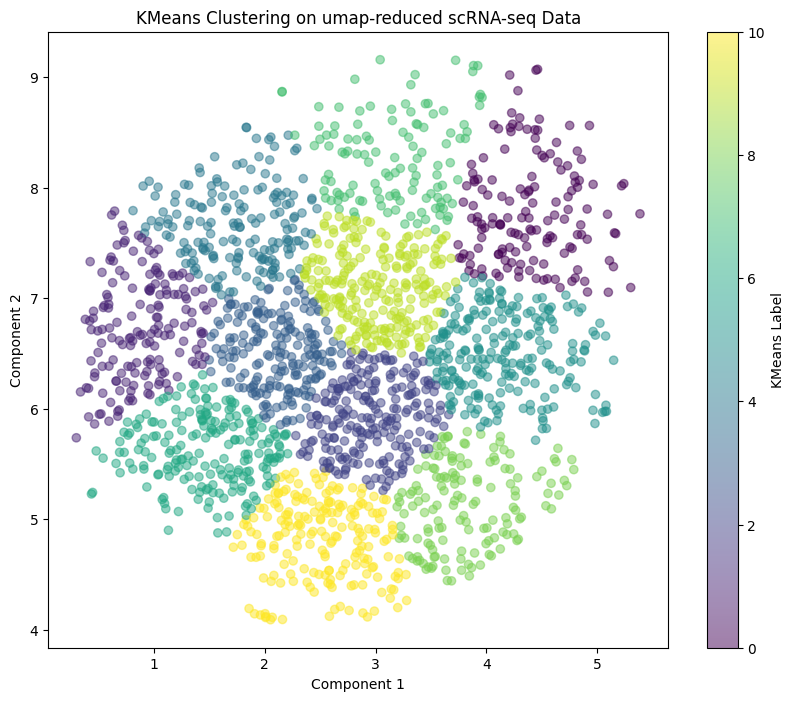

time: 5.729387283325195


In [ ]:
t_umap = results_plotting2d(X_normalized,"umap", n_clusters=11)
print(f"time: {t_umap}")

====> Epoch: 138 Average loss: 93.6974
====> Epoch: 139 Average loss: 93.7415
====> Epoch: 140 Average loss: 93.7493
====> Epoch: 141 Average loss: 93.6678
====> Epoch: 142 Average loss: 93.6857
====> Epoch: 143 Average loss: 93.5956
====> Epoch: 144 Average loss: 93.6819
====> Epoch: 145 Average loss: 93.5773
====> Epoch: 146 Average loss: 93.6138
====> Epoch: 147 Average loss: 93.5679
====> Epoch: 148 Average loss: 93.5675
====> Epoch: 149 Average loss: 93.4938
====> Epoch: 150 Average loss: 93.4839
====> Epoch: 151 Average loss: 93.4636
====> Epoch: 152 Average loss: 93.4853
====> Epoch: 153 Average loss: 93.4118
====> Epoch: 154 Average loss: 93.4247
====> Epoch: 155 Average loss: 93.4176
====> Epoch: 156 Average loss: 93.3507
====> Epoch: 157 Average loss: 93.3809
====> Epoch: 158 Average loss: 93.3519
====> Epoch: 159 Average loss: 93.3856
====> Epoch: 160 Average loss: 93.3020
====> Epoch: 161 Average loss: 93.3169
====> Epoch: 162 Average loss: 93.3508
====> Epoch: 163 Average 

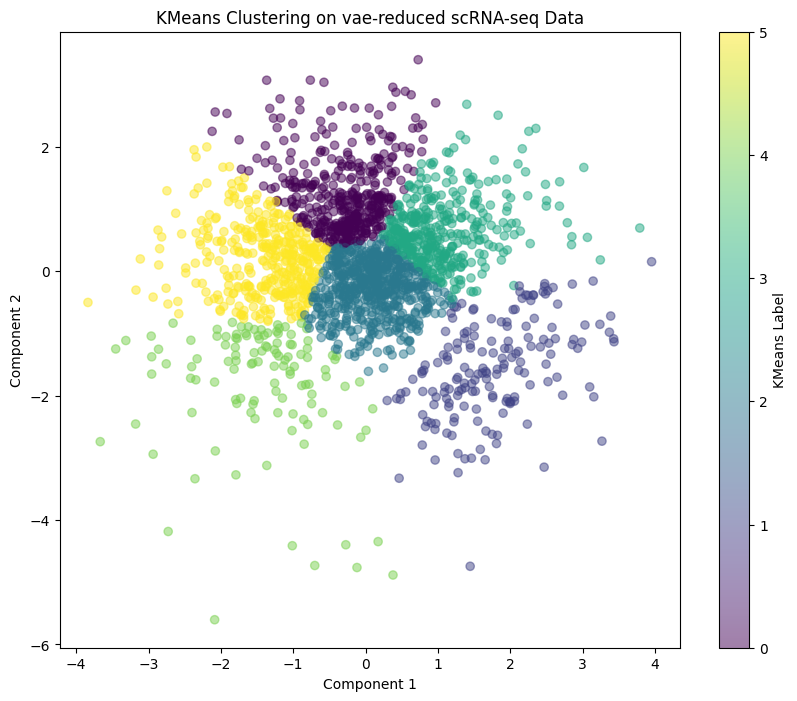

In [ ]:
vae_time_pbmc,X_pbmc_torch= test_vae(X_normalized)


In [ ]:
# Get original labels
original_labels = LabelEncoder().fit_transform(normalized_data.obs['celltype'])

# Assuming the number of unique cell types is the target number of clusters
n_clusters = len(np.unique(original_labels))

# Run the tests
evaluation_results_pbmc = test_clustering_methods(X_normalized, original_labels, n_clusters,n_components=50)

print("\nOverall Evaluation Results:")
for method, scores in evaluation_results_pbmc.items():
  print(f"{method}: {scores}")

Testing pca + KMeans...
(2027, 50)
  pca results: {'Accuracy': 0.04489393191909225, 'AMI': np.float64(0.4356397527015242), 'ARI': 0.5383188383315484, 'Silhouette Score': np.float64(0.06594244386247805), 'time': 0.9348247051239014}
Testing tsne + KMeans...
(2027, 50)
  tsne results: {'Accuracy': 0.11198815984213123, 'AMI': np.float64(0.07017608779836053), 'ARI': 0.02336152073493953, 'Silhouette Score': np.float32(0.04866736), 'time': 426.2895085811615}
Testing umap + KMeans...
(2027, 50)
  umap results: {'Accuracy': 0.10310804144055254, 'AMI': np.float64(0.021613148194830095), 'ARI': 0.00650387666552886, 'Silhouette Score': np.float32(0.1974503), 'time': 9.514284133911133}

Overall Evaluation Results:
pca: {'Accuracy': 0.04489393191909225, 'AMI': np.float64(0.4356397527015242), 'ARI': 0.5383188383315484, 'Silhouette Score': np.float64(0.06594244386247805), 'time': 0.9348247051239014}
tsne: {'Accuracy': 0.11198815984213123, 'AMI': np.float64(0.07017608779836053), 'ARI': 0.023361520734939

In [ ]:
# Run the tests
evaluation_results_vae_pbmc = test_clustering_methods(X_pbmc_torch, original_labels, n_clusters,n_components=50,methods = ["vae"])

Testing vae + KMeans...
====> Epoch: 1 Average loss: 774.8623
====> Epoch: 2 Average loss: 168.8939
====> Epoch: 3 Average loss: 122.2305
====> Epoch: 4 Average loss: 113.6368
====> Epoch: 5 Average loss: 110.4056
====> Epoch: 6 Average loss: 109.7775
====> Epoch: 7 Average loss: 109.0746
====> Epoch: 8 Average loss: 107.8000
====> Epoch: 9 Average loss: 107.4639
====> Epoch: 10 Average loss: 106.8213
====> Epoch: 11 Average loss: 106.5342
====> Epoch: 12 Average loss: 106.2478
====> Epoch: 13 Average loss: 106.0739
====> Epoch: 14 Average loss: 105.5398
====> Epoch: 15 Average loss: 104.6113
====> Epoch: 16 Average loss: 104.8120
====> Epoch: 17 Average loss: 103.7488
====> Epoch: 18 Average loss: 103.7161
====> Epoch: 19 Average loss: 103.1686
====> Epoch: 20 Average loss: 102.9780
====> Epoch: 21 Average loss: 102.3046
====> Epoch: 22 Average loss: 101.8190
====> Epoch: 23 Average loss: 101.6110
====> Epoch: 24 Average loss: 101.2306
====> Epoch: 25 Average loss: 100.9530
====> Epoc

In [ ]:
evaluation_results_pbmc.update(evaluation_results_vae_pbmc)

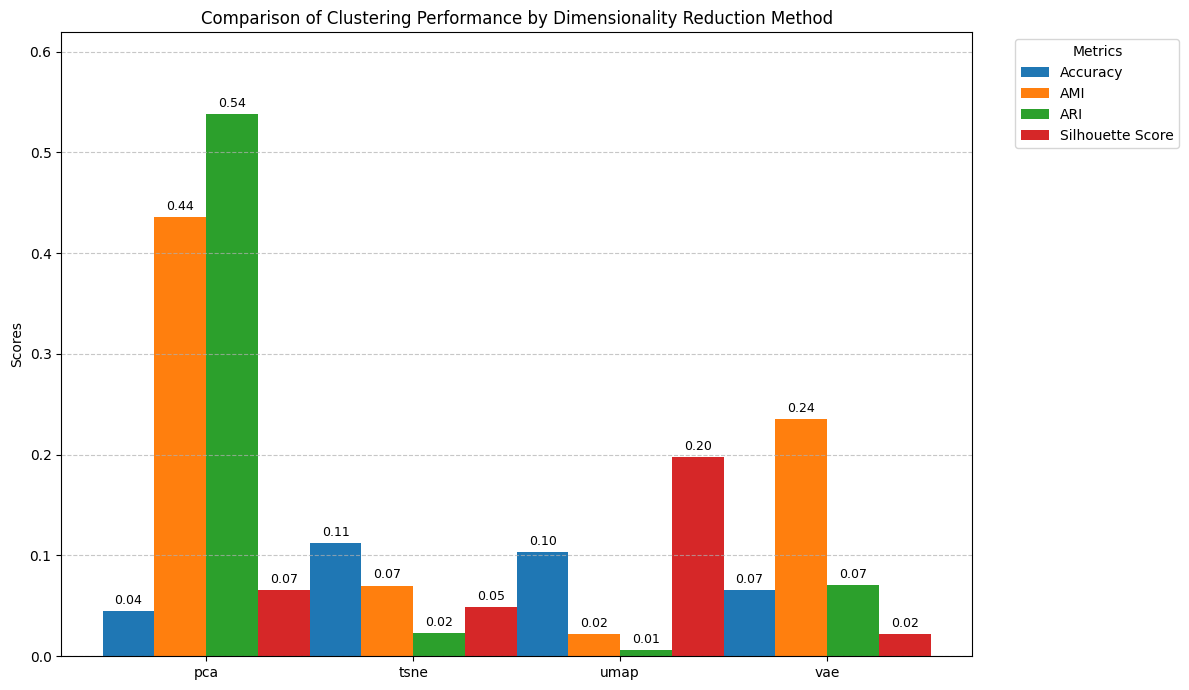

In [ ]:
plot_results(evaluation_results_pbmc)

## chu

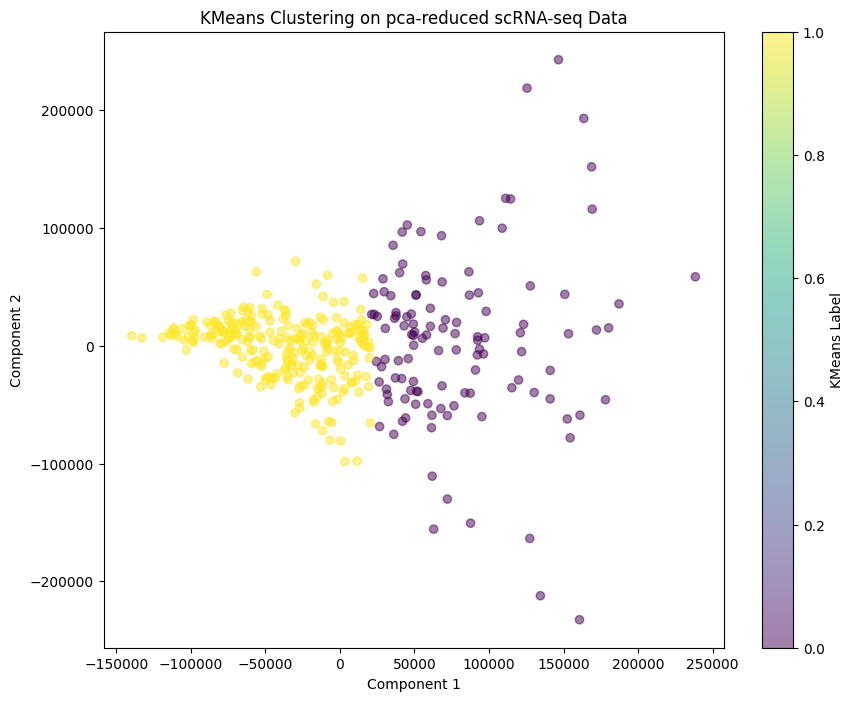

time = 0.38994312286376953


In [ ]:
t_pca_chu = results_plotting2d(X_chu,"pca",n_clusters=2)
print(f"time = {t_pca_chu }")

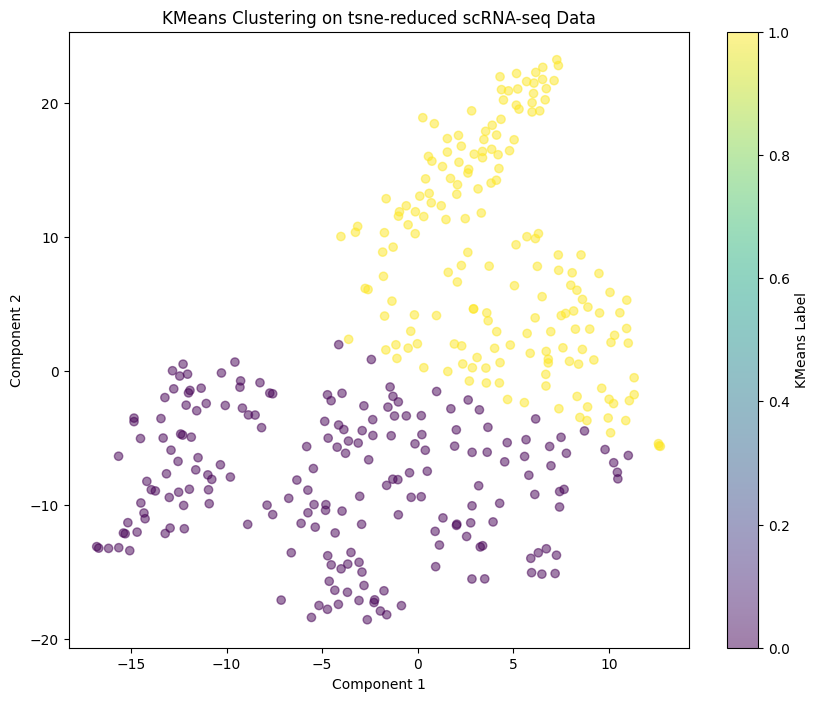

time = 2.078611135482788


In [ ]:
t_tsne_chu = results_plotting2d(X_chu,"tsne",n_clusters=2)
print(f"time = {t_tsne_chu}")

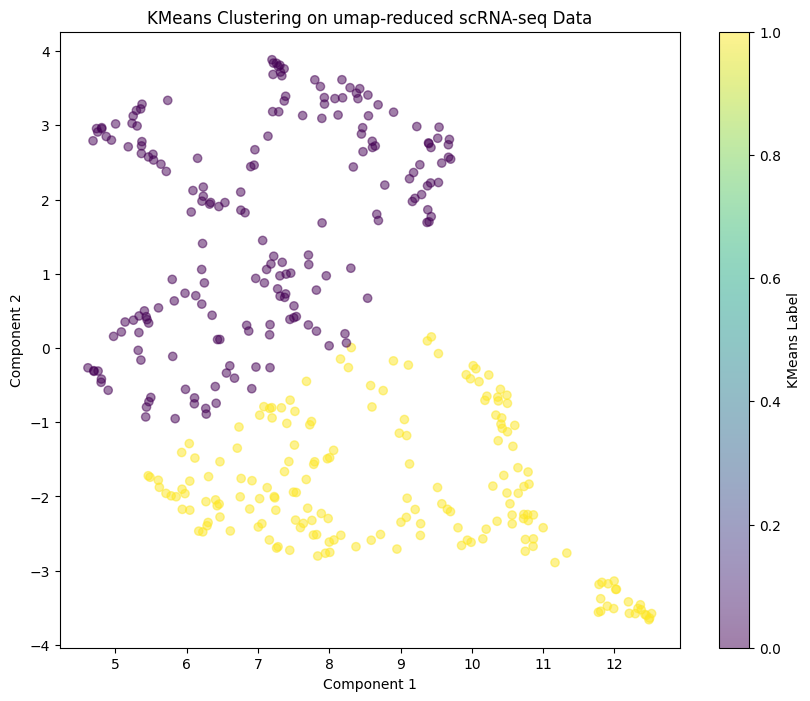

time = 1.3228895664215088


In [ ]:
t_umap_chu = results_plotting2d(X_chu,"umap",n_clusters=2)
print(f"time = {t_umap_chu}")

cuda
tensor(True, device='cuda:0')
====> Epoch: 1 Average loss: 12189.1016
====> Epoch: 2 Average loss: 7584.6768
====> Epoch: 3 Average loss: 5310.7734
====> Epoch: 4 Average loss: 4855.7002
====> Epoch: 5 Average loss: 4599.2266
====> Epoch: 6 Average loss: 4394.2190
====> Epoch: 7 Average loss: 4277.8357
====> Epoch: 8 Average loss: 4184.4815
====> Epoch: 9 Average loss: 4110.4238
====> Epoch: 10 Average loss: 4042.0538
====> Epoch: 11 Average loss: 3998.8660
====> Epoch: 12 Average loss: 3969.4447
====> Epoch: 13 Average loss: 3948.0907
====> Epoch: 14 Average loss: 3936.0435
====> Epoch: 15 Average loss: 3911.1057
====> Epoch: 16 Average loss: 3906.6122
====> Epoch: 17 Average loss: 3899.3004
====> Epoch: 18 Average loss: 3888.9227
====> Epoch: 19 Average loss: 3871.4380
====> Epoch: 20 Average loss: 3884.7863
====> Epoch: 21 Average loss: 3863.1756
====> Epoch: 22 Average loss: 3859.7513
====> Epoch: 23 Average loss: 3851.9052
====> Epoch: 24 Average loss: 3855.0855
====> Epoch: 

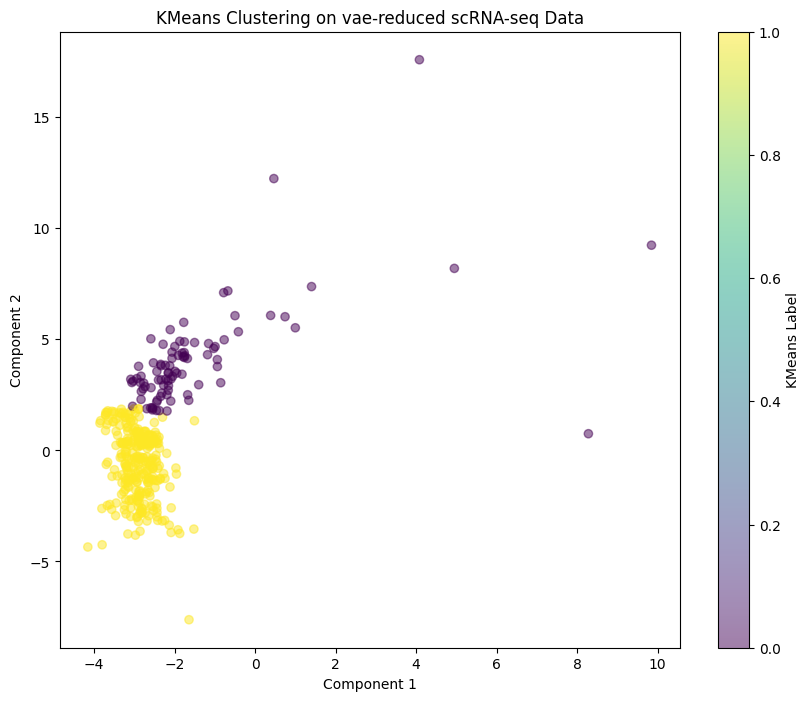

In [ ]:

def test_vae(X):

    from sklearn.preprocessing import MinMaxScaler


    # Assuming X_chu is your raw data in a NumPy array
    # 1. Scale the data to the [0, 1] range
    scaler = MinMaxScaler(clip=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # if device.type == 'cuda':
    #     torch.cuda.synchronize()

    X_scaled = scaler.fit_transform(X)

    print(device)
    # 2. Convert the scaled data to a PyTorch tensor
    X_chu_torch = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    in_bounds = ((X_chu_torch >= 0) & (X_chu_torch <= 1)).all()

    print(in_bounds)  # prints: tensor(True) if all in [0,1], else tensor(False)
    t4 = results_plotting2d(X_chu_torch,"vae",n_clusters=2)

    return t4,X_chu_torch

vae_time_chu,X_chu_torch= test_vae(X_chu)

# print(f"time = {t4}")

In [ ]:
# Get original labels
original_labels = chu_labels

# Assuming the number of unique cell types is the target number of clusters
n_clusters = len(np.unique(original_labels))

# Run the tests
evaluation_results_chu = test_clustering_methods(X_chu, original_labels, n_clusters,n_components=100,methods = ["pca", "tsne", "umap"])

print("\nOverall Evaluation Results:")
for method, scores in evaluation_results_chu.items():
  print(f"{method}: {scores}")


Testing pca + KMeans...
(374, 100)
  pca results: {'Accuracy': 0.42245989304812837, 'AMI': np.float64(0.00799658653673257), 'ARI': 0.0194334129966733, 'Silhouette Score': np.float32(0.37948543), 'time': 1.4812266826629639}
Testing tsne + KMeans...
(374, 100)
  tsne results: {'Accuracy': 0.6631016042780749, 'AMI': np.float64(0.07594039463923412), 'ARI': 0.10403026840496381, 'Silhouette Score': np.float32(0.30763564), 'time': 12.533068656921387}
Testing umap + KMeans...
(374, 100)
  umap results: {'Accuracy': 0.6336898395721925, 'AMI': np.float64(0.10397748332725543), 'ARI': 0.06668503991552853, 'Silhouette Score': np.float32(0.43452656), 'time': 1.5439190864562988}

Overall Evaluation Results:
pca: {'Accuracy': 0.42245989304812837, 'AMI': np.float64(0.00799658653673257), 'ARI': 0.0194334129966733, 'Silhouette Score': np.float32(0.37948543), 'time': 1.4812266826629639}
tsne: {'Accuracy': 0.6631016042780749, 'AMI': np.float64(0.07594039463923412), 'ARI': 0.10403026840496381, 'Silhouette S

In [ ]:
# testing vae
evaluation_results_vae_chu = test_clustering_methods(X_chu_torch, original_labels, n_clusters,n_components=100,methods = ["vae"])


Testing vae + KMeans...
====> Epoch: 1 Average loss: 12504.0117
====> Epoch: 2 Average loss: 8194.5353
====> Epoch: 3 Average loss: 6101.8681
====> Epoch: 4 Average loss: 5265.2488
====> Epoch: 5 Average loss: 4886.1471
====> Epoch: 6 Average loss: 4720.2811
====> Epoch: 7 Average loss: 4492.7234
====> Epoch: 8 Average loss: 4327.2879
====> Epoch: 9 Average loss: 4262.7676
====> Epoch: 10 Average loss: 4203.0637
====> Epoch: 11 Average loss: 4161.1131
====> Epoch: 12 Average loss: 4101.5418
====> Epoch: 13 Average loss: 4050.0383
====> Epoch: 14 Average loss: 4014.5693
====> Epoch: 15 Average loss: 3995.9537
====> Epoch: 16 Average loss: 3974.7057
====> Epoch: 17 Average loss: 3974.5534
====> Epoch: 18 Average loss: 3965.7622
====> Epoch: 19 Average loss: 3948.1752
====> Epoch: 20 Average loss: 3940.7854
====> Epoch: 21 Average loss: 3914.4375
====> Epoch: 22 Average loss: 3913.1268
====> Epoch: 23 Average loss: 3902.5977
====> Epoch: 24 Average loss: 3896.0251
====> Epoch: 25 Average 

In [ ]:
evaluation_results_chu.update(evaluation_results_vae_chu)

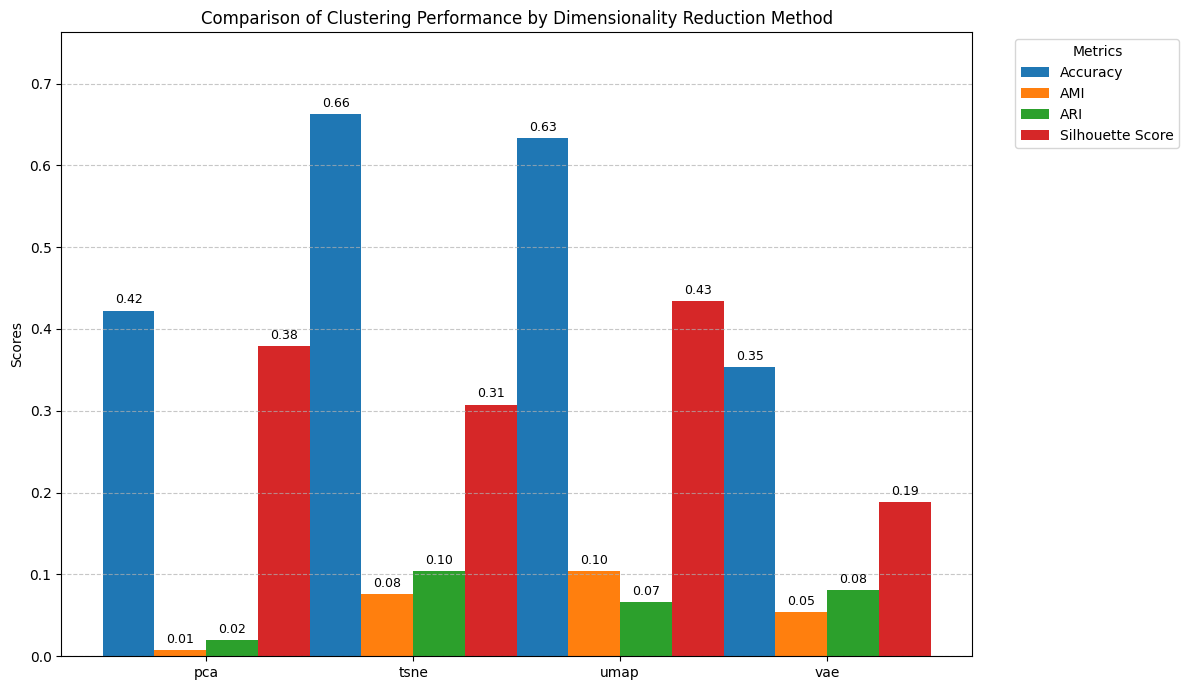

In [ ]:
plot_results(evaluation_results_chu)

# other

In [ ]:
!wget https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/600/E-MTAB-2600/Files/E-MTAB-2600.sdrf.txt

--2025-07-02 06:11:24--  https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/600/E-MTAB-2600/Files/E-MTAB-2600.sdrf.txt
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 787940 (769K) [text/plain]
Saving to: ‘E-MTAB-2600.sdrf.txt’

E-MTAB-2600.sdrf.tx 100%[===================>] 769.47K  1002KB/s    in 0.8s    

2025-07-02 06:11:26 (1002 KB/s) - ‘E-MTAB-2600.sdrf.txt’ saved [787940/787940]



In [ ]:
!wget https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/061/E-MTAB-5061/Files/pancreas_refseq_rpkms_counts_3514sc.txt

--2025-07-02 06:11:26--  https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/061/E-MTAB-5061/Files/pancreas_refseq_rpkms_counts_3514sc.txt
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 722957491 (689M) [text/plain]
Saving to: ‘pancreas_refseq_rpkms_counts_3514sc.txt’

pancreas_refseq_rpk 100%[===================>] 689.47M  30.6MB/s    in 25s     

2025-07-02 06:11:52 (27.6 MB/s) - ‘pancreas_refseq_rpkms_counts_3514sc.txt’ saved [722957491/722957491]



In [ ]:
with open("pancreas_refseq_rpkms_counts_3514sc.txt",'r') as f:
    print(f.readline(500))

#samples	HP1502401_N13	HP1502401_D14	HP1502401_F14	HP1502401_J13	HP1502401_B13	HP1502401_H13	HP1502401_J14	HP1502401_B14	HP1502401_A14	HP1502401_C14	HP1502401_G14	HP1502401_E14	HP1502401_L14	HP1502401_M14	HP1502401_K14	HP1502401_I14	HP1502401_F13	HP1502401_L13	HP1502401_D13	HP1502401_H14	HP1504101T2D_I3	HP1504101T2D_D16	HP1504101T2D_D22	HP1502401_F17	HP1504101T2D_B4	HP1504101T2D_M6	HP1504101T2D_F15	HP1504101T2D_H7	HP1502401_H23	HP1504101T2D_F8	HP1502401_L21	HP1502401_B19	HP1504101T2D_B2	HP150410


In [ ]:
df_segerstolpe = pd.read_csv(
    "pancreas_refseq_rpkms_counts_3514sc.txt",
    sep="\t",
    index_col=0,
    skiprows=1
)

In [ ]:
!head -n 2 pancreas_refseq_rpkms_counts_3514sc.txt | cat -A


#samples^IHP1502401_N13^IHP1502401_D14^IHP1502401_F14^IHP1502401_J13^IHP1502401_B13^IHP1502401_H13^IHP1502401_J14^IHP1502401_B14^IHP1502401_A14^IHP1502401_C14^IHP1502401_G14^IHP1502401_E14^IHP1502401_L14^IHP1502401_M14^IHP1502401_K14^IHP1502401_I14^IHP1502401_F13^IHP1502401_L13^IHP1502401_D13^IHP1502401_H14^IHP1504101T2D_I3^IHP1504101T2D_D16^IHP1504101T2D_D22^IHP1502401_F17^IHP1504101T2D_B4^IHP1504101T2D_M6^IHP1504101T2D_F15^IHP1504101T2D_H7^IHP1502401_H23^IHP1504101T2D_F8^IHP1502401_L21^IHP1502401_B19^IHP1504101T2D_B2^IHP1504101T2D_F10^IHP1504101T2D_B10^IHP1504101T2D_L6^IHP1502401_G18^IHP1502401_K22^IHP1502401_I22^IHP1504101T2D_M18^IHP1502401_J22^IHP1502401_F4^IHP1504101T2D_O12^IHP1502401_M15^IHP1504101T2D_G16^IHP1502401_J5^IHP1504101T2D_L23^IHP1502401_G24^IHP1502401_G23^IHP1504101T2D_H11^IHP1504101T2D_A24^IHP1504101T2D_N17^IHP1502401_N8^IHP1504101T2D_G1^IHP1504101T2D_A15^IHP1504101T2D_M19^IHP1502401_O16^IHP1504101T2D_E16^IHP1502401_A12^IHP1502401_D18^IHP1504101T2D_K2^IHP1504101T2D_G1

In [ ]:
df_["HP1526901T2D_A8"]

NameError: name 'df_' is not defined

In [ ]:
!head -n 10 pancreas_refseq_rpkms_counts_3514sc.txt
